### Acknowledgement and Sources: 

I used queries to ChatGPT to learn about useful tools for manipulating numpy arrays. Specifically, I used queries to learn about np.full and np.zeros, which can both be used to construct numpy arrays of a specified shape, initialized to different values. I also used queries to learn about the .ravel function, which can be used to flatten matrices into vectors. This was especially useful for the process of converting nPrint files into individual vector samples. I also used queries to learn about the TruncatedSVD class in sklearn, and the cumsum function of numpy, which were useful in projecting data onto principal components and plotting the explained variance as a function of the number of principal directions used. I also used queries to learn about the following sklearn classes: SGDClassifier, LabelEncoder, ConfusionMatrixDisplay. These classes helped me to build linear classifiers with different loss functions, encode categorial lables into a list of integers, and plot confusion matrices for each of the classifiers that I trained. Moreover, I used queries to learn about the label_binarize function and the roc_curve function, which were useful in creating multi-class ROC plots for each of my classifiers. I also used queries to learn about the feature_importances_ attribute of RandomForest models in sklearn, which I used in my code that analyzes the feature importances of this dataset in relation to the operating system detection task.

### Processing and Visualizing the OS Benchmark Dataset

In [1]:
import os
import glob
import numpy as np
import pandas as pd

disallowed_features = ["ipv4_src", "ipv4_dst", "tcp_sport", "tcp_dport", "tcp_seq", "tcp_ack", "tcp_sprt", "tcp_dprt", "udp_sport", "udp_dport", "udp_sprt", "udp_dprt"]

def check_disallowed_feature(column_name):
    name = column_name.lower()
    return any(feature in name for feature in disallowed_features)

pcapml_metadata = pd.read_csv("parsed_pcapng_data/metadata.csv")
pcap_to_os = dict(zip(pcapml_metadata["File"], pcapml_metadata["Label"]))
nprint_files = sorted(glob.glob("nprint_samples/*.npt"))

all_colummns = pd.read_csv(nprint_files[0], nrows=0).columns.tolist()
index_col, feature_columns = all_colummns[0], all_colummns[1:]
allowed_feature_columns = [col for col in feature_columns if not check_disallowed_feature(col)]

data_rows = []
max_length = 0

for path in nprint_files:
    base = os.path.basename(path)
    pcap_name = base[:-4] + ".pcap" 

    label = pcap_to_os.get(pcap_name)
    include_columns = [index_col] + allowed_feature_columns
    nprint_df = pd.read_csv(path, usecols=include_columns)
    nprint_arr = nprint_df[allowed_feature_columns].to_numpy(dtype=np.int16, copy=False)

    flattened = nprint_arr.ravel()
    if flattened.shape[0] > max_length:
        max_length = flattened.shape[0]

    sample_id = pcap_name[:-5]
    data_rows.append((sample_id, label, flattened))

X = np.full((len(data_rows), max_length), -1, dtype=np.int16)
sample_ids = np.empty(len(data_rows), dtype=object)
y = np.empty(len(data_rows), dtype=object)

for i, (sample_id, label, flattened_arr) in enumerate(data_rows):
    sample_ids[i], y[i], X[i, :flattened_arr.shape[0]] = sample_id, label, flattened_arr

print(f"Shape of feature matrix X: {X.shape}")
print(f"Shape of label vector y: {y.shape}")
print(f"Number of operating system type labels: {len(set(y.tolist()))}")

Shape of feature matrix X: (12439, 79900)
Shape of label vector y: (12439,)
Number of operating system type labels: 13


In [2]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)

#### Principal Components Analysis

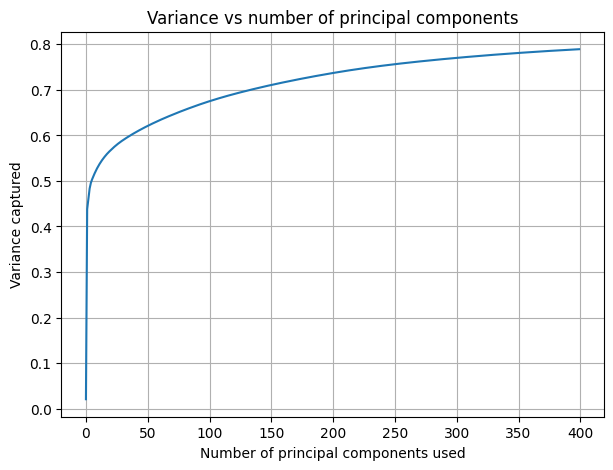

In [3]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
num_principal_components = 400

truncated_svd = TruncatedSVD(n_components=num_principal_components, random_state=0)
X_train_reduced = truncated_svd.fit_transform(X_train)
X_test_reduced = truncated_svd.transform(X_test)
variance_cdf = np.cumsum(truncated_svd.explained_variance_ratio_)

plt.figure(figsize=(7, 5))
plt.plot(variance_cdf)
plt.xlabel("Number of principal components used")
plt.ylabel("Variance captured")
plt.title("Variance vs number of principal components")
plt.grid(True)
plt.show()

#### Analysis: 
We can observe that a relatively small number of the principal components (<50) can explain a large portion (~50%) of the variance in the data. This is illustrated by the slower rate of growth that occurs close the point on the x-axis corresponding to approximately 50 components. For this task, I will not perform thorough dimensionality reduction on this dataset, since I do not wish to lose any information about the attributes of samples and how they relate to operating system type. Although a small number of principal components explain a significant amount of varation, a large number of principal components is still needed to fully capture the underlying distribution.

### Testing Classification Models for OS Detection Benchmark

#### Perceptron Classifier

Balanced accuracy score for Perceptron classifier is 0.6347692307692306


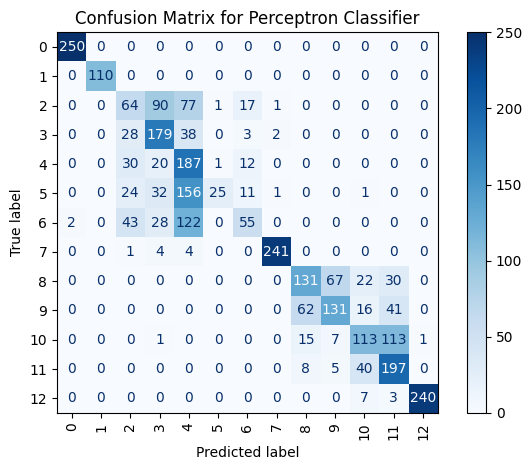

In [4]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

perceptron_model = SGDClassifier(loss="perceptron", max_iter=100, tol=1e-3, n_jobs=-1, random_state=0)
perceptron_model.fit(X_train, y_train_encoded)
y_predicted = perceptron_model.predict(X_test)

balanced_accuracy = balanced_accuracy_score(y_test_encoded, y_predicted)
confusion_matrix_data = confusion_matrix(y_test_encoded, y_predicted)

print(f"Balanced accuracy score for Perceptron classifier is {balanced_accuracy}")
confusion_plot = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_data)
confusion_plot.plot(cmap="Blues", xticks_rotation="vertical")

plt.title("Confusion Matrix for Perceptron Classifier")
plt.tight_layout()
plt.show()

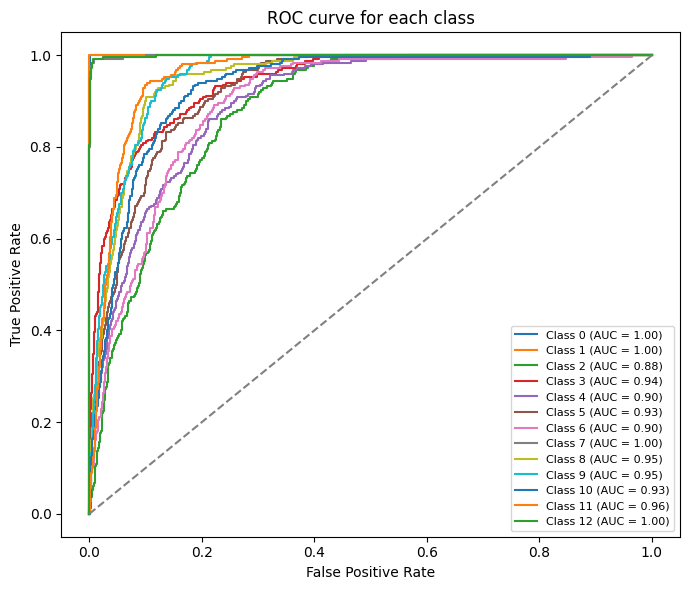

In [5]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

os_classes = np.unique(y_test_encoded)
binarized_outputs = label_binarize(y_test_encoded, classes=os_classes)
predictions = perceptron_model.decision_function(X_test)

plt.figure(figsize=(7, 6))
for i, class_number in enumerate(os_classes):
    false_positive_rate, true_positive_rate, _ = roc_curve(binarized_outputs[:, i], predictions[:, i])
    area_under_curve = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, label=f"Class {class_number} (AUC = {area_under_curve:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve for each class")
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()

#### Analysis: 
The perceptron model performed relatively well on this task, obtaining a balanced accuracy score of 0.6348. Moreover, the confusion matrix also shows a high density of correctly classified samples across its diagonal, and the ROC curves have relatively high AUC values which are close to 1. Although the balanced accuracy score is worse than that of the benchmark, it nevertheless reveals that the data contains certain features which relate linearly to the operating system labels, and that linear classifiers can still achieve a reasonable degree of accuracy. 

#### Logistic Regression Classifier

Balanced accuracy score for Logistic Regression classifier is 0.636


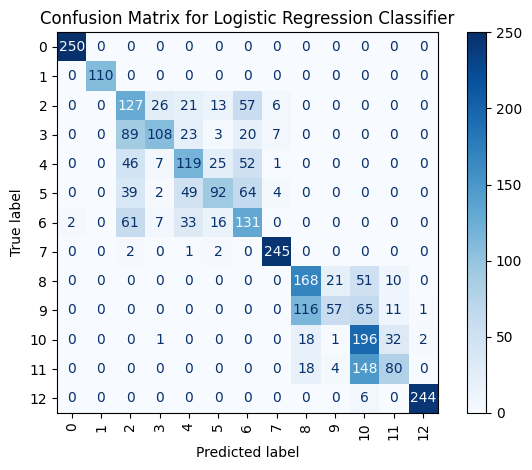

In [6]:
logistic_regression = SGDClassifier(loss="log_loss", max_iter=100, tol=1e-3, n_jobs=-1, random_state=0)
logistic_regression.fit(X_train, y_train_encoded)
y_predicted = logistic_regression.predict(X_test)

balanced_accuracy = balanced_accuracy_score(y_test_encoded, y_predicted)
confusion_matrix_data = confusion_matrix(y_test_encoded, y_predicted)

print(f"Balanced accuracy score for Logistic Regression classifier is {balanced_accuracy}")

confusion_plot = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_data)
confusion_plot.plot(cmap="Blues", xticks_rotation="vertical")

plt.title("Confusion Matrix for Logistic Regression Classifier")
plt.tight_layout()
plt.show()

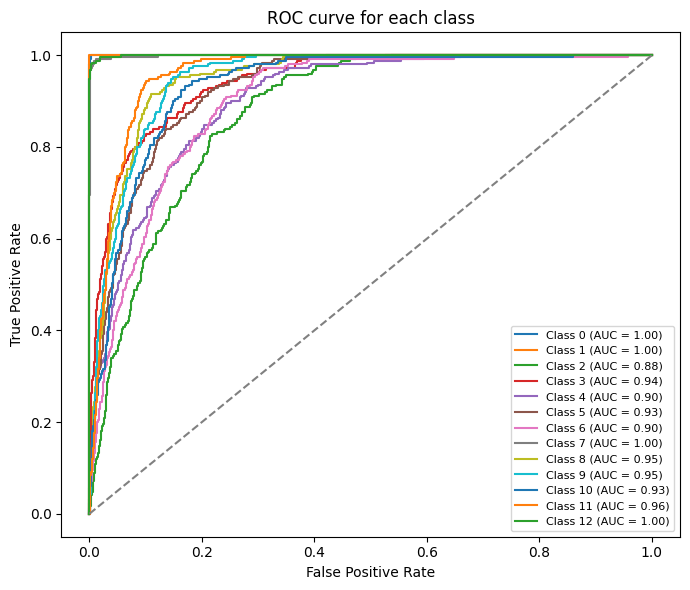

In [7]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

os_classes = np.unique(y_test_encoded)
binarized_outputs = label_binarize(y_test_encoded, classes=os_classes)
predictions = logistic_regression.decision_function(X_test)

plt.figure(figsize=(7, 6))
for i, class_number in enumerate(os_classes):
    false_positive_rate, true_positive_rate, _ = roc_curve(binarized_outputs[:, i], predictions[:, i])
    area_under_curve = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, label=f"Class {class_number} (AUC = {area_under_curve:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve for each class")
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()

#### Analysis: 
The perceptron model performed relatively well on this task, obtaining a balanced accuracy score of 0.636, which is slightly higher than that of the perceptron model, though still below that of the benchmark. The confusion matrix shows a high density of correctly classified samples across its diagonal, and the ROC curves have relatively high AUC values which are close to 1. The performance of this model further verifies that linear classifiers can be useful in operating system type detection, suggesting that there exist certain features in packet trace data that relate linearly to the labels.

#### Support Vector Machine Classifier

Balanced accuracy score for Support Vector Machine classifier is 0.6495384615384615


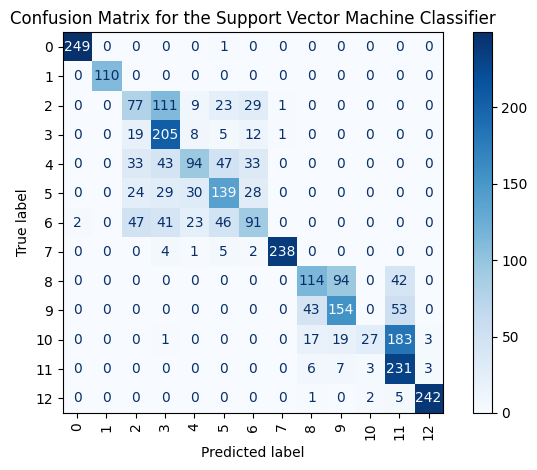

In [8]:
support_vector_machine = SGDClassifier(loss="hinge", max_iter=100, tol=1e-3, n_jobs=-1, random_state=0)
support_vector_machine.fit(X_train, y_train_encoded)
y_predicted = support_vector_machine.predict(X_test)

balanced_accuracy = balanced_accuracy_score(y_test_encoded, y_predicted)
confusion_matrix_data = confusion_matrix(y_test_encoded, y_predicted)

print(f"Balanced accuracy score for Support Vector Machine classifier is {balanced_accuracy}")

confusion_plot = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_data)
confusion_plot.plot(cmap="Blues", xticks_rotation="vertical")

plt.title("Confusion Matrix for the Support Vector Machine Classifier")
plt.tight_layout()
plt.show()

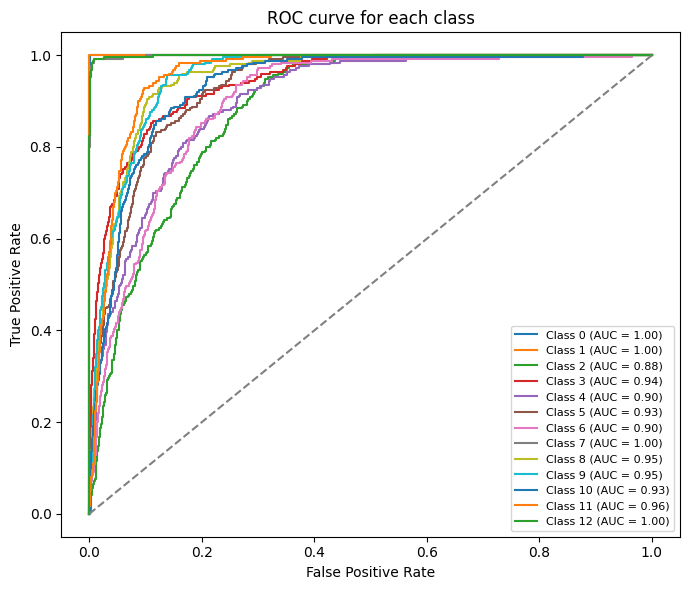

In [9]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

os_classes = np.unique(y_test_encoded)
binarized_outputs = label_binarize(y_test_encoded, classes=os_classes)
predictions = support_vector_machine.decision_function(X_test)

plt.figure(figsize=(7, 6))
for i, class_number in enumerate(os_classes):
    false_positive_rate, true_positive_rate, _ = roc_curve(binarized_outputs[:, i], predictions[:, i])
    area_under_curve = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, label=f"Class {class_number} (AUC = {area_under_curve:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve for each class")
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()

#### Analysis: 
The support vector machine model also performed well on this task, obtaining a balanced accuracy score of 0.6495, which is slightly higher than that of the logistic regression model and the perceptron model, though also still below that of the benchmark. The confusion matrix shows a high density of correctly classified samples across its diagonal, and the ROC curves have relatively high AUC values which are close to 1. It makes sense that this model performed slightly better than the other linear classifiers, as the support vector machine attempts to minimize hinge loss, which as the effect of creating a larger margin between the decision boundary and correctly classified samples.

#### Random Forest Classifier

Balanced accuracy score for RandomForest classifier is 0.7538461538461539


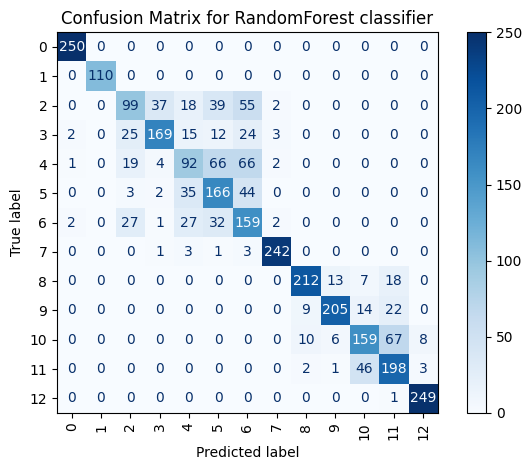

In [10]:
from sklearn.ensemble import RandomForestClassifier

random_forest_model = RandomForestClassifier(n_estimators=200, max_depth=None, n_jobs=-1, random_state=0)
random_forest_model.fit(X_train, y_train_encoded)
y_predicted = random_forest_model.predict(X_test)

balanced_accuracy = balanced_accuracy_score(y_test_encoded, y_predicted)
confusion_matrix_data = confusion_matrix(y_test_encoded, y_predicted)

print(f"Balanced accuracy score for RandomForest classifier is {balanced_accuracy}")

confusion_plot = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_data)
confusion_plot.plot(cmap="Blues", xticks_rotation="vertical")

plt.title("Confusion Matrix for RandomForest classifier")
plt.tight_layout()
plt.show()

##### Multi-class ROC Curve for RandomForest

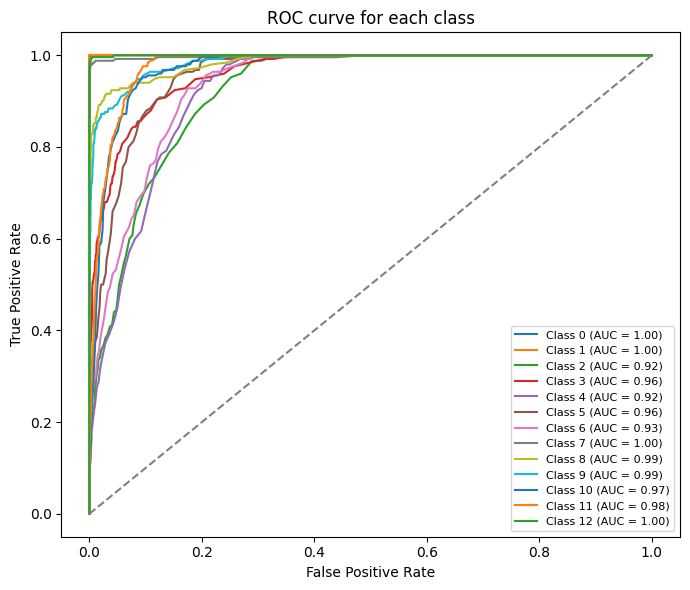

In [11]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

os_classes = np.unique(y_test_encoded)
binarized_outputs = label_binarize(y_test_encoded, classes=os_classes)
predictions = random_forest_model.predict_proba(X_test)

plt.figure(figsize=(7, 6))
for i, class_number in enumerate(os_classes):
    false_positive_rate, true_positive_rate, _ = roc_curve(binarized_outputs[:, i], predictions[:, i])
    area_under_curve = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, label=f"Class {class_number} (AUC = {area_under_curve:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve for each class")
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()

#### Analysis: 
The RandomForest performed especially well on this task, obtaining a balanced accuracy score of 0.7538, which is significantly higher than that of the all of the previous linear classifiers, though it is still slightly below the benchmark score of 0.771. The confusion matrix shows a high density of correctly classified samples across its diagonal, and the ROC curves have relatively high AUC values which are close to 1. The performance of this model suggests that even though linear classifiers can be useufl in predicting operating system type from features in nPrint representations, there is still value to be gained in learning nonlinear relationships in the data using models such as decision trees.

### Analyzing Feature Importance for OS Benchmark 

In [12]:
feature_count = len(allowed_feature_columns)
random_forest_importance = random_forest_model.feature_importances_
feature_importances = np.zeros(feature_count)
for i, importance_score in enumerate(random_forest_importance):
    feature_importances[i % feature_count] += importance_score

idx_importance = list(enumerate(feature_importances))
descending_importance = sorted(idx_importance, key=lambda x: x[1], reverse=True)
important_features = descending_importance[:25]

print(f"The 25 most important data features in relation to operating system label:")
for i, importance_score in important_features:
    print(f"{allowed_feature_columns[i]}: {importance_score}")

The 25 most important data features in relation to operating system label:
ipv4_ttl_0: 0.04362525575543767
tcp_wsize_1: 0.040161115194404
tcp_wsize_5: 0.03722557930422077
ipv4_ttl_1: 0.0330576743626257
tcp_wsize_0: 0.025806975574175946
tcp_opt_42: 0.018350167342298135
tcp_opt_40: 0.018242783458630757
tcp_opt_41: 0.017995247931869324
tcp_opt_36: 0.01562198043241877
tcp_opt_34: 0.015242432564923353
ipv4_id_15: 0.013722452929194127
tcp_opt_67: 0.012071715837647124
ipv4_cksum_15: 0.01201821718587505
ipv4_tos_4: 0.011862407308706064
ipv4_cksum_0: 0.011428291470529602
tcp_wsize_3: 0.011136352971437896
tcp_wsize_6: 0.010846328239851703
tcp_wsize_2: 0.010749857378714936
tcp_wsize_15: 0.00997642892264809
tcp_opt_20: 0.009616115766152386
tcp_opt_68: 0.00943904259724781
ipv4_id_14: 0.009421783457776181
tcp_opt_39: 0.008934015465546079
tcp_opt_44: 0.008825548939955189
ipv4_ttl_5: 0.008462549154142502


#### Analysis: 
We can observe that based on the RandomForest model that was trained, the most important featuers in the data relate to the following attributes: time-to-live, TCP window sizes, TCP options, and IP address checksum values. It makes sense that the RandomForest model identified these features as having the highest predictive value in determining operating system type, since every operating system sets unique values for certain fields when sending packets. Specifically, attributes such as time-to-live differ based on the operating system sending packets, which explains why it is one of the most important features in this task.